# Cognition & Computation

Project of Davide Mazza, n. 7029608

#Introduction

The objective of this project is to implement simulations to explore computational models of visual concept learning, specifically focusing on unsupervised learning in generative models using a Deep Belief Network (DBN). We aim to make sense of the representations learned by the DBN through visualization techniques such as analyzing receptive fields and clustering representation.

To further evaluate the performance of the DBN, we will incorporate a Linear-ReadOut (LRO) and compare it with a Feed Forward Neural Network. By adding the LRO, we can assess how well the DBN's representations can be utilized for classification tasks. Additionally, we will probe both models by injecting noisy data to understand their robustness to sensory perturbations and make a comparative analysis.

Furthermore, we will explore the models' responses and resilience to adversarial attacks, examining their vulnerabilities and behavior in the face of perturbations aimed at deceiving them.


To start with, let's download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import string
import random
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import seaborn as sns

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


#Dataset

The EMNIST dataset is an extended and modified version of the popular MNIST dataset used for handwritten digit recognition. Unlike MNIST, which only contains digits from 0 to 9, EMNIST includes both uppercase and lowercase alphabetic characters in addition to digits. In this project is considered the dataset with handwritten characters, where the images are grayscale and have a resolution of 28x28 pixels.



In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',split= 'letters', train =True, download=True,transform=tv.transforms.ToTensor())
emnist_test = tv.datasets.EMNIST('data/',split= 'letters', train = False, download=True,transform=tv.transforms.ToTensor())

In [6]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)
emnist_train.targets -= 1
emnist_test.targets -= 1

I've shifted targets by 1 so as not to consider the "N/A" label.

In [7]:
#create a dictionary to better understand the labels of each image
alphabet_dict = {i: letter for i, letter in enumerate(string.ascii_lowercase)}


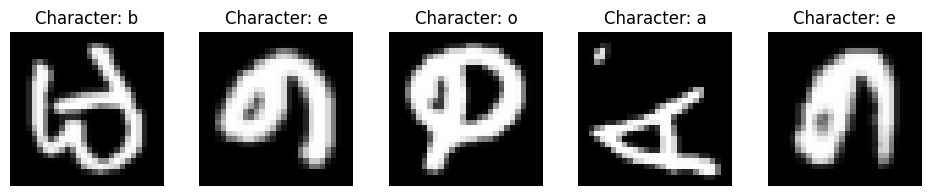

In [69]:
idx = [random.randint(1, 100) for _ in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(12, 2))

for i, ax in enumerate(axes):
    img = emnist_train.data[idx[i]].cpu()
    ax.imshow(img, cmap='gray')
    ax.set_title("Character: {}".format(alphabet_dict[emnist_train.targets[idx[i]].item()]))
    ax.axis('off')
    plt.subplots_adjust(wspace=0.1)

plt.show()

In [9]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

In [10]:
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

Once the dataset has been downloaded and normalized, we can proceed with its exploration.
To begin, we can create a dictionary that contains the labels corresponding to the images. This will allow us to associate each image with its respective label.
Next, we can plot some images from the dataset along with its corresponding label. This visualization will provide us with a better understanding of the data and how the labels are distributed among the images. We can notice that some images are rotate.

# Deep Belief Network
In this section, we introduce our hierarchical generative model architecture, specifically a Deep Belief Network (DBN), which belongs to the family of neural networks designed for unsupervised learning. DBNs consist of multiple layers of Restricted Boltzmann Machines (RBMs), which serve as the fundamental components of Deep Belief Networks. RBMs are undirected probabilistic graphical models. The RBMs in the lower layers of the network specialize in recognizing low-level features present in the input data, while the RBMs in the higher layers excel at capturing more complex features. To construct our DBN, we employ 3 hidden layers comprising 400, 500, and 800 hidden units, respectively. Although two layers proved sufficient for learning features from the data. Some experiments were conducted with four hidden layers; however, the network exhibited signs of overfitting, and the learned features at higher levels did not provide additional utility in pattern detection The visible layer, representing the input, consists of 28*28 units since each EMNIST image encompasses 784 pixels. Prior to fine-tuning the network using supervised learning for classification tasks, we perform unsupervised pre-training on the DBN. This pre-training phase facilitates the initialization of the network's weights and biases. Furthermore, we set and initialize essential hyperparameters such as the learning rate and the number of epochs. With all preparations in place, we commence the unsupervised training of the network using the EMNIST dataset. This dataset serves as the foundation for training and evaluating the performance of our DBN.

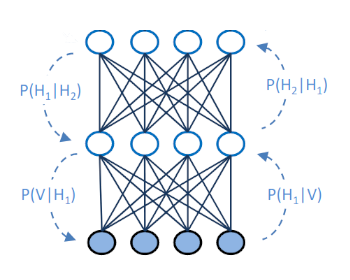

In [11]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

num_epochs = 50
batch_size = 200

With these hyperparameters set, we proceeded with training the DBN for 50 epochs, using a batch size of 200. This ensured a sufficient number of iterations over the dataset while balancing computational resources.

Train the network:

In [12]:
dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.0608     |0.0517       |289.3372   |5.1822     |
|20    |1.9620     |0.0478       |274.1112   |4.1277     |
|30    |1.9332     |0.0497       |267.4134   |4.9032     |
|40    |1.9208     |0.0482       |264.4503   |4.4330     |
|50    |1.9200     |0.0471       |263.7823   |4.0386     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.6035     |0.0525       |196.9114   |2.8194     |
|20    |2.5002     |0.0526       |192.9027   |2.9479     |
|30    |2.4793     |0.0523       |190.8489   |2.8297     |
|40    |2.4728     |0.0505       |190.3665   |2.5767     |
|50    |2.4669     |0.0531       |190.5955   |2.5691     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8487     |0.0421       |238.8096   |3.6497     |
|20    |1.7095     |0.0372       |225.2267   |3.323

During the training phase, we observe a consistent decrease in the average reconstruction error and a reduction in the standard deviation of the reconstruction error as the number of training epochs increases. This trend signifies that the network is progressively improving its ability to reconstruct the input data with greater accuracy over time. Overall, these results indicate successful training of the network.

#Linear Read Out

Once the unsupervised learning phase is completed, we can add an output layer that encodes the labels. This output layer is fully connected to the deepest hidden layer, forming a linear pattern associator that can be trained using supervised learning. We employ a linear classifier to assess the separability of each hidden layer representations, in order to evaluate how much information is contained in each hidden representatation.

In [13]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [14]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Here, we define an usual function to train the linear classifier using backpropagation.

In [15]:
def train_linear(linear, hidden_reprs, epochs=1500):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()


  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

Here, we define a function that return the hidden representation for each hidden layer.

In [16]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [17]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [18]:
train_linear(linear1, hidden_repr_layer_1)
train_linear(linear2, hidden_repr_layer_2)
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 3.2609
epoch : 101/1500, loss = 2.1258
epoch : 201/1500, loss = 1.6849
epoch : 301/1500, loss = 1.4756
epoch : 401/1500, loss = 1.3542
epoch : 501/1500, loss = 1.2733
epoch : 601/1500, loss = 1.2143
epoch : 701/1500, loss = 1.1684
epoch : 801/1500, loss = 1.1313
epoch : 901/1500, loss = 1.1002
epoch : 1001/1500, loss = 1.0738
epoch : 1101/1500, loss = 1.0507
epoch : 1201/1500, loss = 1.0303
epoch : 1301/1500, loss = 1.0122
epoch : 1401/1500, loss = 0.9958
epoch :   1/1500, loss = 3.2754
epoch : 101/1500, loss = 2.0877
epoch : 201/1500, loss = 1.6608
epoch : 301/1500, loss = 1.4641
epoch : 401/1500, loss = 1.3505
epoch : 501/1500, loss = 1.2746
epoch : 601/1500, loss = 1.2188
epoch : 701/1500, loss = 1.1753
epoch : 801/1500, loss = 1.1400
epoch : 901/1500, loss = 1.1104
epoch : 1001/1500, loss = 1.0850
epoch : 1101/1500, loss = 1.0629
epoch : 1201/1500, loss = 1.0433
epoch : 1301/1500, loss = 1.0257
epoch : 1401/1500, loss = 1.0098
epoch :   1/1500, loss = 3.267

The loss decreases  which indicates that the model is improving in its ability to make accurate classifications, now let's test the model to evaluate the accuracy of the classifications using the test set.

In [19]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [20]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [21]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [22]:
acc1 = compute_accuracy(predictions_test1, emnist_test.targets)
acc2 = compute_accuracy(predictions_test2, emnist_test.targets)
acc3 = compute_accuracy(predictions_test3, emnist_test.targets)
pd.DataFrame({'Accuracy': [acc1, acc2, acc3]}, index=["Hidden layer 1", "Hidden layer 2", "Hidden layer 3",])

,Accuracy
Hidden layer 1,0.725673
Hidden layer 2,0.718942
Hidden layer 3,0.749038


Here we get the hidden representation and calculate the accuracy for the classifications made for each layer. As we can see we have accuracies that are around 73%, with higher accuracies in the deepest layer, this makes sense as the DBN learns more and more complex details of the inputs going deeper into the layers.


#Confusion Matrix

A confusion matrix is an evaluation metric to assess the performance of a classification model. It provides a detailed breakdown of the model's predictions by comparing them to the true labels of the test data. The matrix is organized into rows and columns, where each row corresponds to a true class, and each column corresponds to a predicted class. The cells of the matrix represent the count or proportion of data points that fall into each combination of true and predicted classes.
By analyzing the confusion matrix, we can gain insights into the model's performance across different classes. It helps us understand the types of errors the model makes, such as false positives (misclassifying a sample as positive when it is actually negative) and false negatives (misclassifying a sample as negative when it is actually positive). The confusion matrix provides a comprehensive overview of the model's predictive performance, making it a valuable tool for assessing and comparing the effectiveness of different classification algorithms.

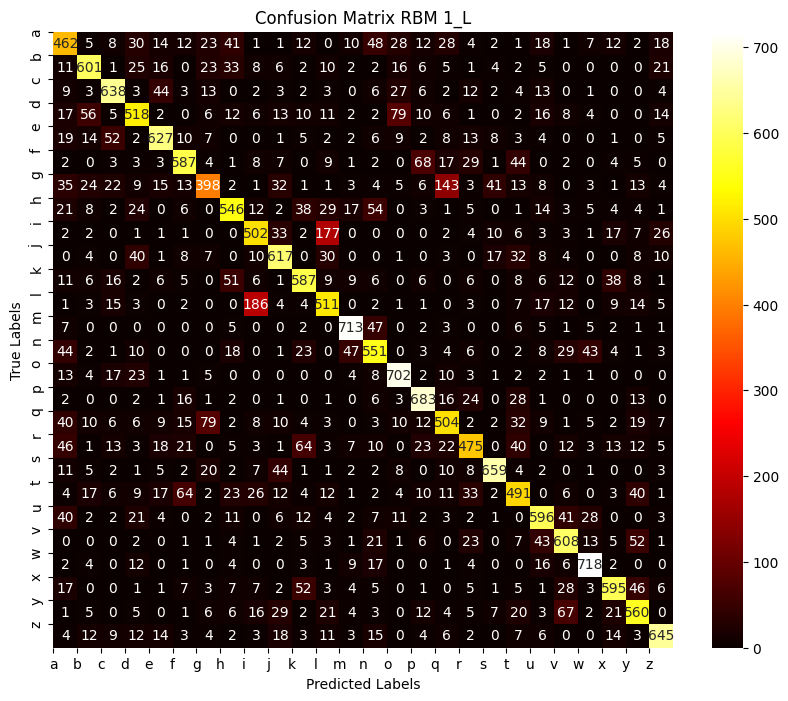

In [23]:
from sklearn.metrics import confusion_matrix
labels=alphabet_dict.values()

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="hot")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.show()


plot_confusion_matrix(emnist_test.targets.tolist(), predictions_test1.max(axis=1).indices.tolist(), labels, "Confusion Matrix RBM 1_L")


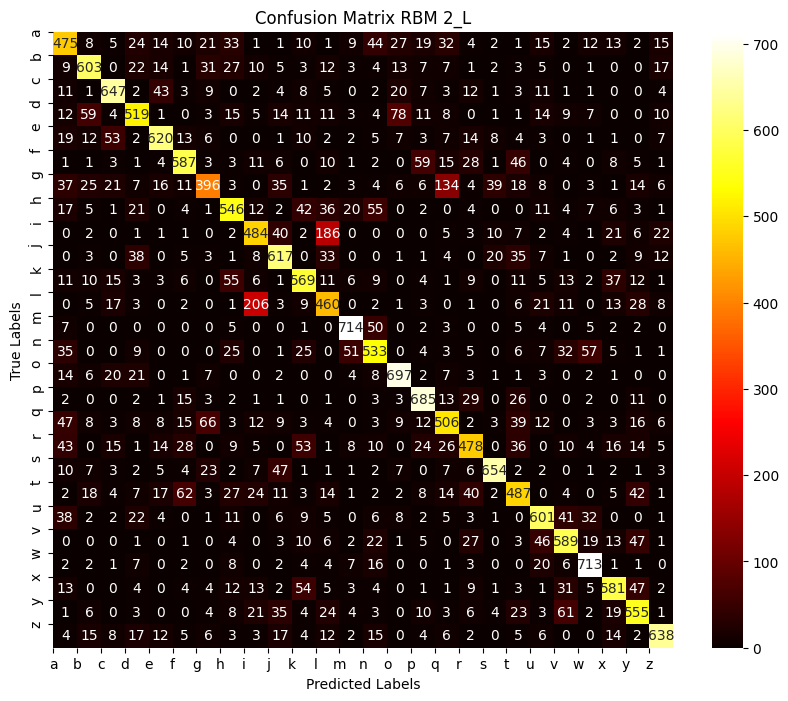

In [24]:
plot_confusion_matrix(emnist_test.targets.tolist(), predictions_test2.max(axis=1).indices.tolist(), labels, "Confusion Matrix RBM 2_L")


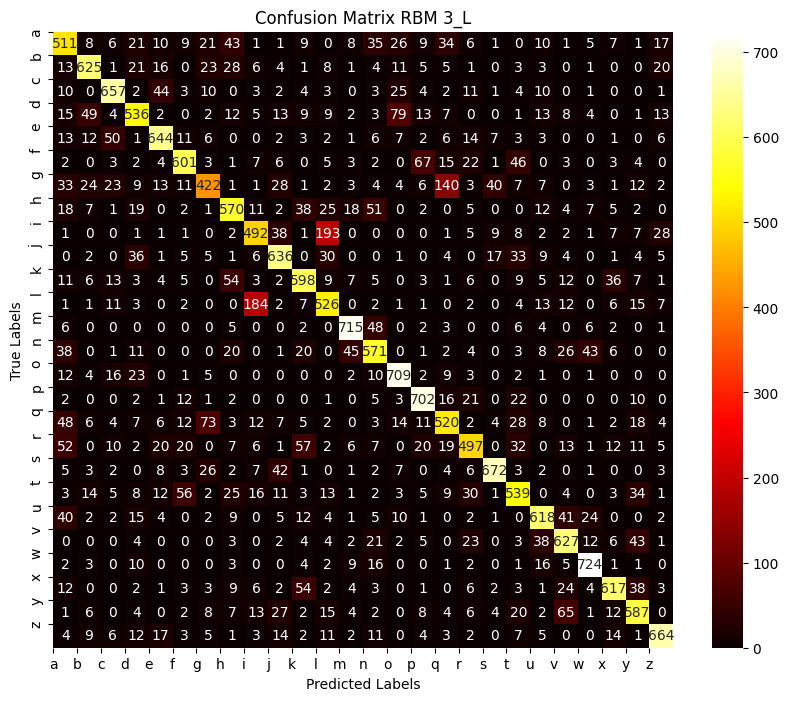

In [25]:
plot_confusion_matrix(emnist_test.targets.tolist(), predictions_test3.max(axis=1).indices.tolist(), labels, "Confusion Matrix RBM 3_L")


As we can see from these Confusion Matrices, the letters that DBN has the most trouble classifying are "i" and "l," "q" and "g." Also as we go further into the layers of the DBN the misclassifications decrease slightly, that is, the numbers that lie outside the diagonal, as shown above by accuracy.

#Visualizing receptive fields

A DBN has the ability to uncover hidden information that may be inaccessible to other systems. In a DBN, each hidden unit receives inputs from a subset of visible units, and the receptive field of a hidden unit represents the region in the input space influenced by those visible units. These receptive fields provide insights into how well the network processes the input data. When the receptive fields of a DBN cover a specific area of the input space, it suggests that the network is effectively learning to identify particular patterns or features in the data. Understanding the receptive fields of a DBN is crucial in unraveling how the network encodes and processes the input data. This knowledge enables us to gain insights into the underlying representations learned by the network, shedding light on the internal workings and capabilities of the DBN.

In [26]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights, set_of_neurons):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  fig.suptitle(set_of_neurons)
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

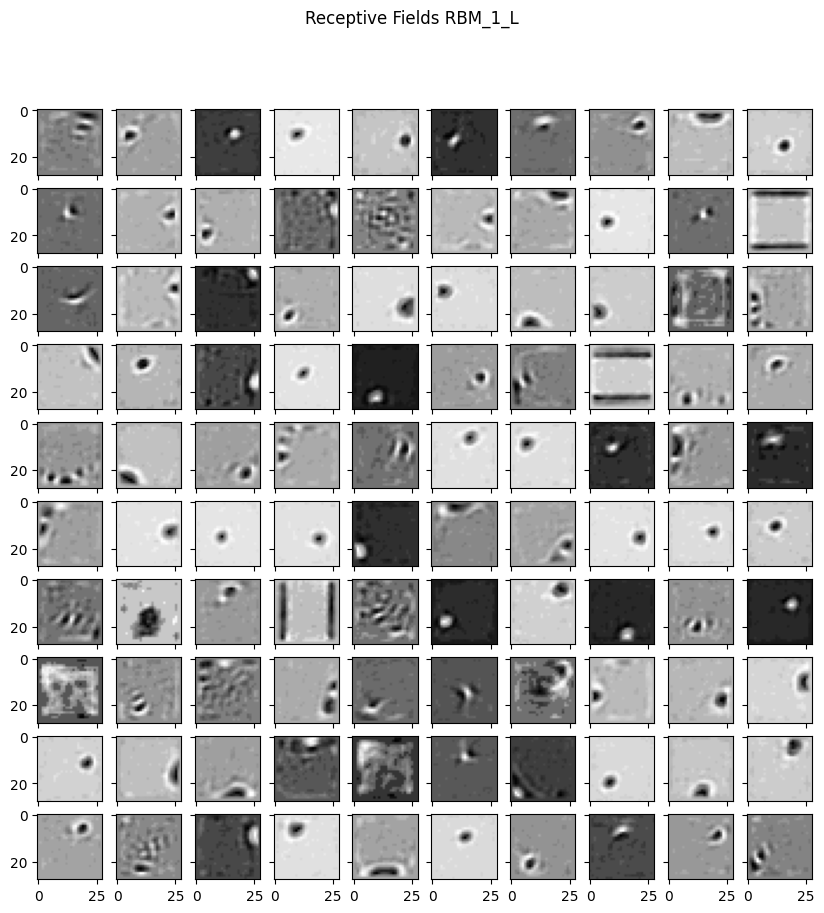

In [27]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)
plot_layer_receptive_fields(learned_weights_layer_1.T, "Receptive Fields RBM_1_L")

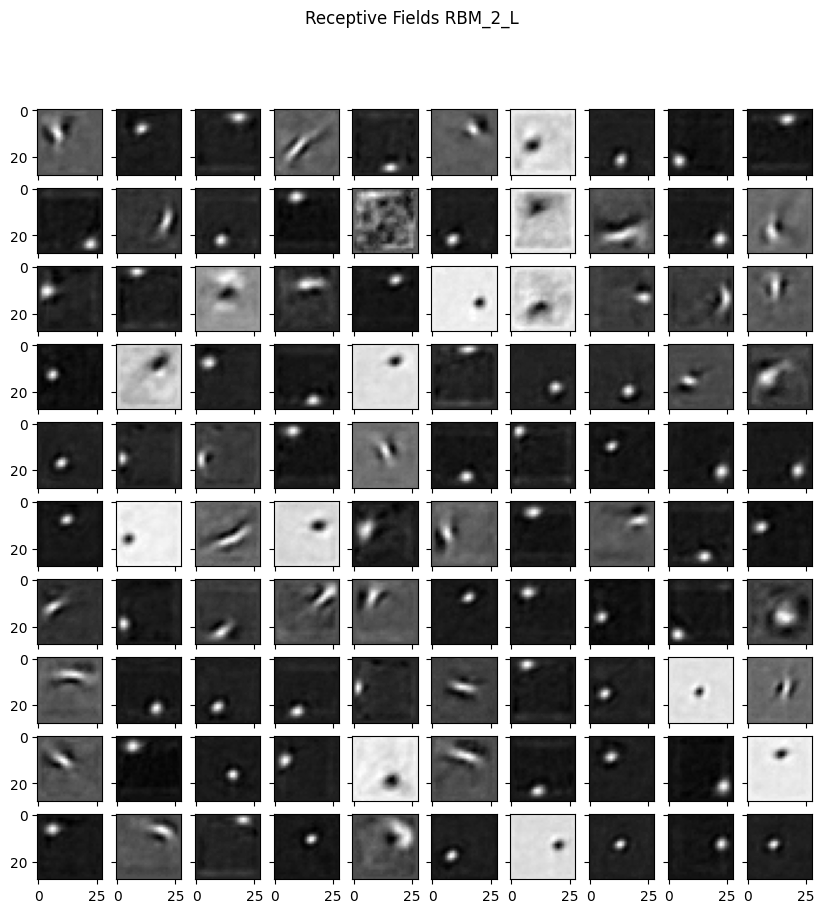

In [28]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T, "Receptive Fields RBM_2_L")

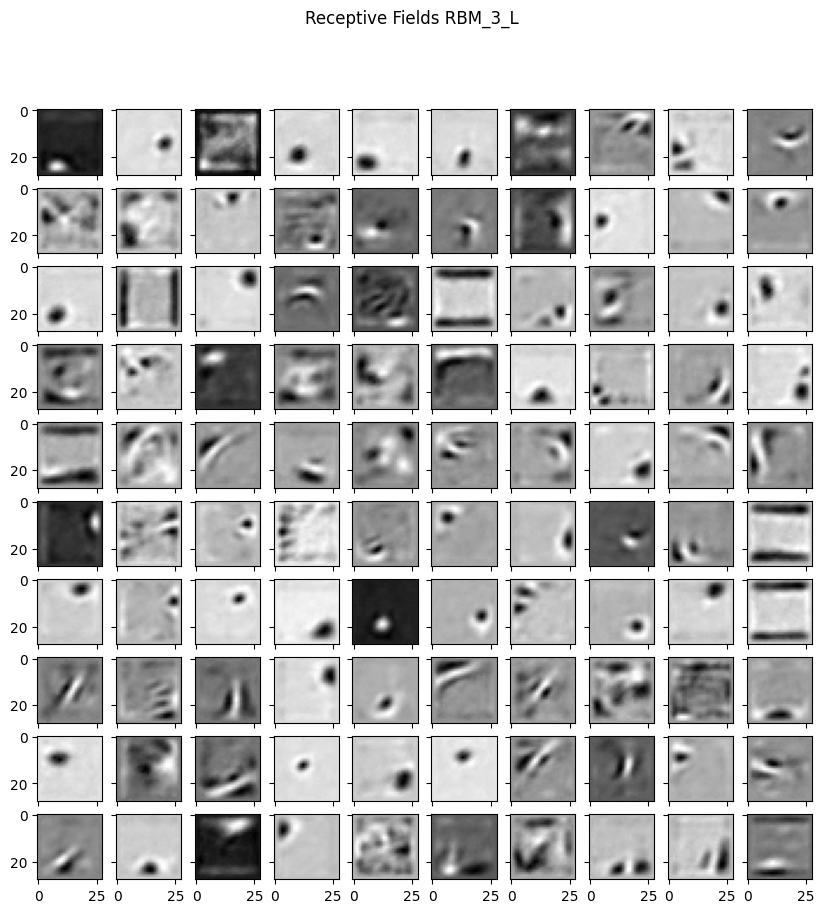

In [29]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T, "Receptive Fields RBM_3_L")

Due to the hierarchical learning process, the representations in the last layer tend to be more focused and selective, resulting in clearer and more distinct visual patterns related to the letters. The network has learned to encode the essential features necessary for letter recognition, leading to sharper and more recognizable images at this stage. It's important to note that this phenomenon may vary depending on the specific architecture, training data, and optimization techniques employed. However, the general idea remains that the deeper layers of a well-trained DBN capture increasingly complex and meaningful representations, which can manifest as clearer images in the final layer.

# Hierarchical clustering

Hierarchical clustering is a method used to group similar data points together based on their similarity. It creates a hierarchy of clusters by merging or splitting existing clusters. The process starts with each data point as its own cluster and gradually merges them until all data points are in a single cluster. The results are visualized using a dendrogram, which shows the hierarchical relationships between clusters.

In [30]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(26)])

In [31]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [32]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  labels = list(string.ascii_lowercase[:mean_repr_matrix.shape[0]])
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=labels)
  ax.set_title(title)

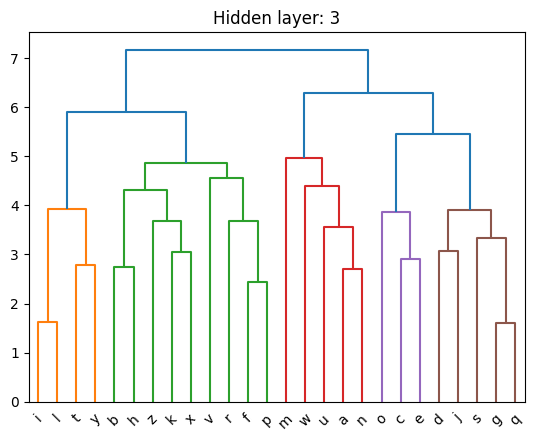

In [33]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Hidden layer: 3")

The dendogram graph shows us which letters are most similar to each other, such as "i" and "l" or "b" and "h". And these will probably be the letters that DBN will have the hardest time classifying

#Comparison with a feed-forward model



Now we are going to compare the results obtained with DBN with a FFNN, which will have the same number and size of layers as before, in order to compare similar structures.
In this part of the project, we are comparing our Deep Belief Network (DBN) with a feed-forward neural network (FFNN). The FFNN is implemented using the provided code.

In [34]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 26)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [35]:
ffnn = Feedforward(400, 500, 800).to(device)

The FFNN consists of three hidden layers with sizes specified as "first_hidden_layer_size," "second_hidden_layer_size," and "third_hidden_layer_size." These layers are linear transformations followed by ReLU activation functions. The input size for the first hidden layer is 784, which corresponds to the number of pixels in each EMNIST image. The output layer is a linear transformation mapping the representation from the third hidden layer to a 26-dimensional space, representing the 26 different classes (letters) in the dataset.

During the forward pass, the input is passed through each layer sequentially. The ReLU activation function is applied to the output of each hidden layer, ensuring non-linearity in the network. Finally, the output is obtained by passing the representation from the third hidden layer through the output layer.

In [36]:
train_linear(ffnn, emnist_train.data.reshape((124800, 784)), epochs=1500)

epoch :   1/1500, loss = 3.2588
epoch : 101/1500, loss = 3.2328
epoch : 201/1500, loss = 3.1334
epoch : 301/1500, loss = 2.5277
epoch : 401/1500, loss = 1.7840
epoch : 501/1500, loss = 1.4981
epoch : 601/1500, loss = 1.3498
epoch : 701/1500, loss = 1.2444
epoch : 801/1500, loss = 1.1654
epoch : 901/1500, loss = 1.1000
epoch : 1001/1500, loss = 1.0424
epoch : 1101/1500, loss = 0.9942
epoch : 1201/1500, loss = 0.9395
epoch : 1301/1500, loss = 0.8900
epoch : 1401/1500, loss = 0.8440


In [37]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [38]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.763894259929657

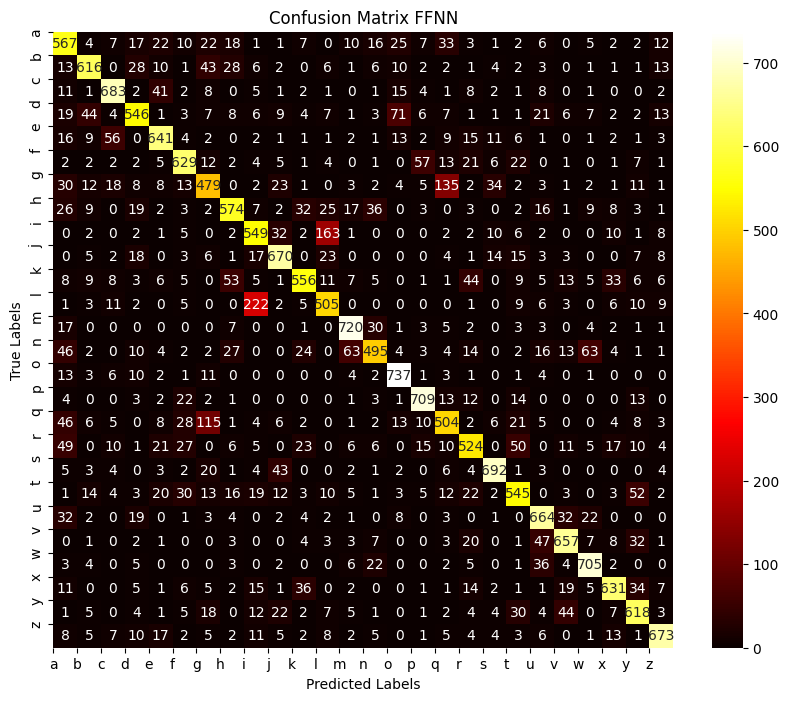

In [39]:
plot_confusion_matrix(emnist_test.targets.tolist(), predictions_ffnn.max(axis=1).indices.tolist(), labels, "Confusion Matrix FFNN")


We can see how the FFNN loss decreases and converges almost to 0, which means that the network works well. Looking at the accuracy we can see that it is very similar to that of DBN, if not slightly better. Same for confusion matrix. To better investigate the comparison obtained from these two models, it would be advisable to introduce noise into the images and evaluate a further comparison given the situation of parity.

#Robustness to noise

 First, we create a tensor with values drawn from a normal distribution with a mean of 0 and variance of 1. Next, we multiply this tensor by the noise level (ε). Finally, we obtain the perturbed dataset by adding the noise tensor to the original data tensor. This process allows us to examine how the models perform when exposed to noisy inputs.

In [40]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

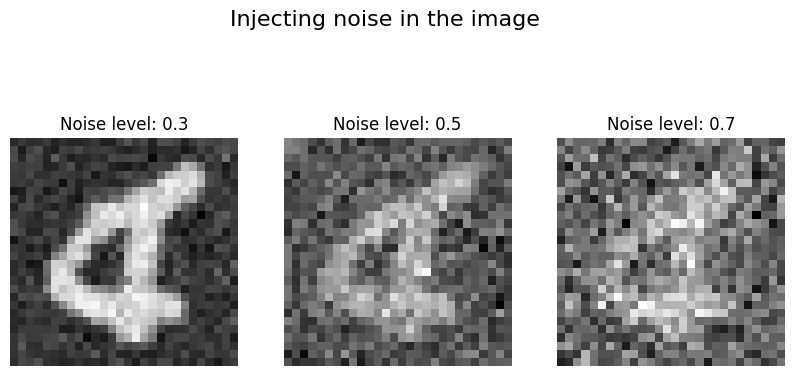

In [41]:
id = 5
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Injecting noise in the image", fontsize=16)
ax = []
noise_level = 0.1
for j in range(3):
    emnist_test_with_noise = inject_noise(emnist_test.data[id], noise_level)
    noise_level += 0.2
    ax.append(fig.add_subplot(1, 3, j+1))
    ax[-1].set_title("Noise level: " + str(round(noise_level, 2)))  # set title
    plt.imshow(emnist_test_with_noise.to('cpu'), cmap = "gray")
    plt.axis('off')
plt.show()

Here we can observe how the sharpness of the image changes (worsens) as the noise level increases. So models will have more difficulty in classifying it.

In [42]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model #<------------
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden,accuracy_ffnn

def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

In [43]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.689
Accuracy of H2 read-out: 0.707
Accuracy of H3 read-out: 0.742
Accuracy of FF network : 0.720


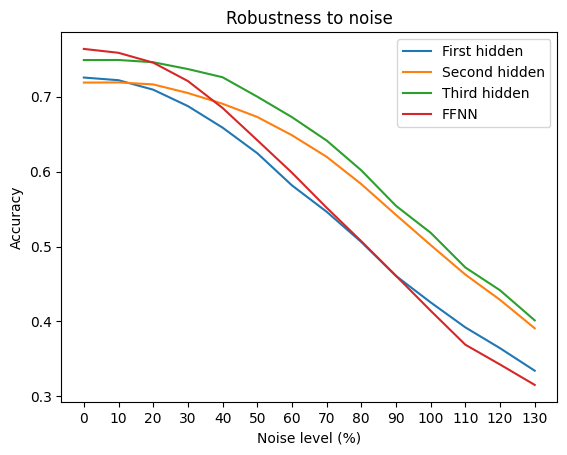

In [44]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

As we can observe from the levels of accuracy with a noise level = 0.3, in the third hidden layer of the DBN we obtain an accuracy of 74%, while in the FFNN we obtain an accuracy of 72%. In this case the DBN performs slightly better, but to ascertain this result with more certainty and on more noise levels we will plot the psycometric curves.

Psycometric curves, in this context, represent the relationship between the noise level and the accuracy of the models. By examining these curves, we can ascertain the robustness of the DBN with respect to FFNN, with different levels of noise.

#Adversarial Attacks


An adversarial attack is an attempt to manipulate a DBN in order to deceive it or induce it to make errors. The primary goal of an adversarial attack is to create input examples that, despite being similar to normal ones, can be misclassified by the model. These examples can be crafted by introducing imperceptible perturbations that are sufficient to fool the model.It can be used to assess the robustness of the models. and it helps in developing defense techniques to make models more secure and reliable.
During model training, we adjust the model's weights by considering the gradient of the loss function in the opposite direction. This is done to minimize the loss and improve the model's performance. However, when generating an adversarial sample, we modify the input instead of the model's weights and move in the same direction as the gradient to maximize the loss function.

The adversarial sample can be expressed as:

x' = x + ε * sign(∇x J(w, x, y))

In the above equation, x represents the original image, ε is a small perturbation value, sign(∇x J(w, x, y)) denotes the sign of the gradient with respect to the input, and x' is the perturbed image.

The following function takes an image and a small epsilon value as inputs. By utilizing the sign of the gradient, we create a small perturbation that is added to the original image. It is important to note that the perturbed image is clamped to ensure that its pixel values remain within the valid range of 0 to 1, as typically expected for normalized pixel values.

In [45]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [46]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [47]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

Let's take a look at the clean image we used earlier to evaluate the effect of noise levels..

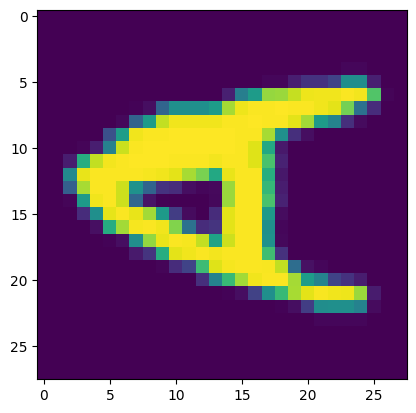

In [48]:
test_image = emnist_test.data[15].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

That is classified by the FFNN as:

In [49]:
attacked_model = ffnn

In [50]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {alphabet_dict[prediction.tolist()]}.")

The prediction of the model for this clean sample is a.


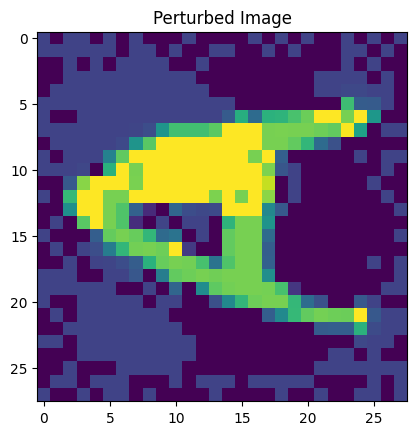

In [51]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[15].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))
plt.title("Perturbed Image")
plt.show()

In [52]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {alphabet_dict[torch.argmax(model_outputs).tolist()]}.")

The prediction of the model for the perturbed sample is r.


We can see how the FFNN misclassifies the image after the perturbation.

In [53]:
attacked_model = dbn_with_readout

In [54]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {alphabet_dict[prediction.tolist()]}.")

The prediction of the model for this clean sample is a.


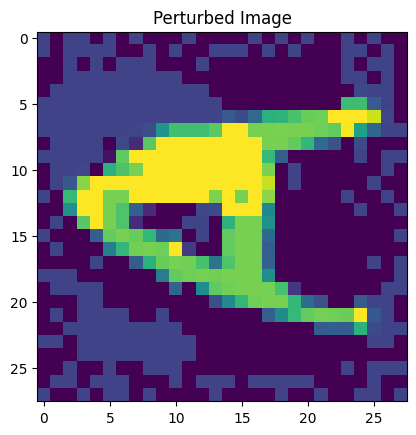

In [55]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[5].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))
plt.title("Perturbed Image")
plt.show()

In [56]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {alphabet_dict[torch.argmax(model_outputs).tolist()]}.")

The prediction of the model for the perturbed sample is k.


From this single example it appears that both models have the same difficulties, but let us evaluate performance more generally before discussing the results.

##Resisting to adversial attack

Now, let's evaluate the robustness of our two models, the feedforward network and the DBN, against adversarial attacks.

Additionally, we will examine the DBN's capability to mitigate the effects of the attack by implementing a "top-down" reconstruction step. This involves reconstructing the visible units from the hidden representation of the last layer, and then reconstructing the hidden representation again.

In [57]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [58]:
emnist_test_1 = tv.datasets.EMNIST('data/',
                                    split='letters',
                                    train =False,
                                    download=False,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )


In [59]:
emnist_test_1.targets -= 1

In [60]:
test_loader = torch.utils.data.DataLoader(
    emnist_test_1,
    batch_size=100, shuffle=True)

Here we can see how FFNN perform in term of accuracy with an epsilon=0.1


In [61]:
from tqdm.notebook import tqdm
import torch.nn.functional as functional

final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 24.12%



Here we can see how DBN performs

In [62]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.62%



And now let's explore the potential for enhancing attack resilience by incorporating a single top-down reconstruction phase from the generative model.

  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



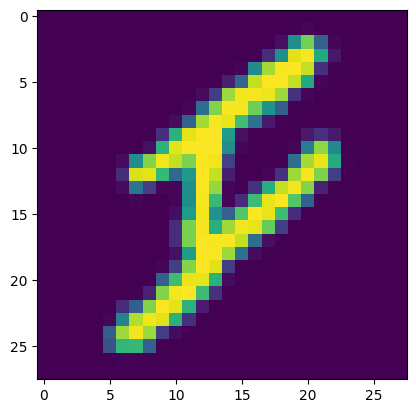


Here's a perturbed sample:



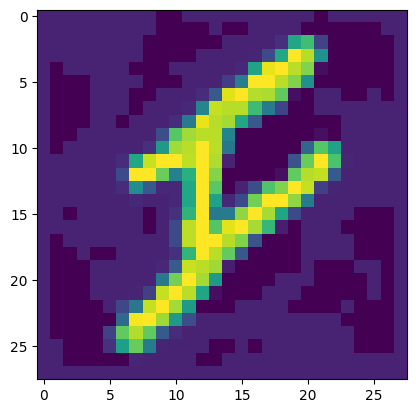


Here's what a 1-steps reconstructed sample looks like:



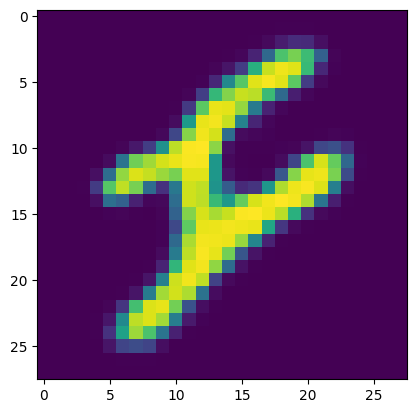


Epsilon: 0.1
Test Accuracy: 59.04%



In [63]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

#Effect of the noise parameter ϵ

In [64]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [65]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

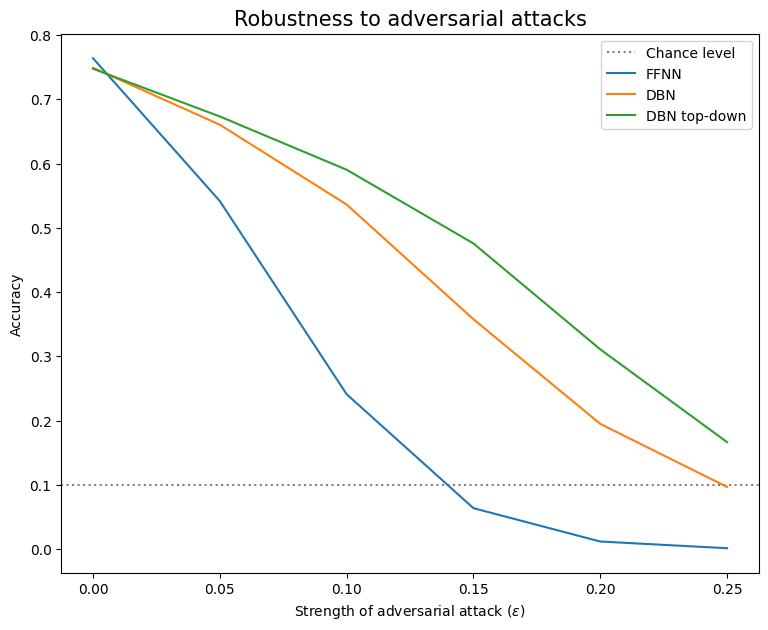

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The reconstructed images displayed above indicate that the model effectively denoises the images, leading to improved accuracy and enhanced resilience against adversarial attacks. Notably, the DBN with top-down reconstruction not only surpasses the performance of the FFNN but also outperforms the DBN without reconstructions.

#Conclusion

Our experimentation with the Deep Belief Network (DBN) and Linear-ReadOut (LRO) has provided valuable insights. The DBN demonstrates its powerful capabilities by learning visual concepts that other networks with similar structures cannot. While the initial accuracies appeared similar, further analysis using confusion matrices and psychometric curves revealed significant differences. It excels in handling noisy data and exhibits strong resistance to adversarial attacks, employing one step of top-down reconstruction in the generative model enhanced its resilience to attacks. With an epsilon value of 0.1, the DBN achieved an accuracy of 59.04%, whereas the FFNN struggled with a mere 24.12%.

In conclusion, the DBN exhibiting promising performance across various evaluation metrics.
